## Assignment 1

## Scraper

In [ ]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.edge.options import Options as EdgeOptions
from selenium.webdriver.common.keys import Keys
import time
import pandas as pd
import re
from bs4 import BeautifulSoup
import time


def timer(func):
    def inner(*args, **kwargs):
        begin = time.time()
        func(*args, **kwargs)
        end = time.time()
        print("Total time taken to run function {}: {} minutes.".format(func.__name__, (end-begin)/60))
    return inner


class EdmundsScraper():
    def __init__(self):
        options = EdgeOptions()
        options.add_experimental_option('excludeSwitches', ['enable-logging'])
        self.driver = webdriver.Edge(options=options)
        self.url_links = []
        self.date_posts = []
        self.text_posts = []

    def get_edmund_comment_links(self, url_link, num_to_pull=200):
        self.url_links.extend([url_link + '/p{}'.format(i+1) for i in range(num_to_pull)])

    @timer
    def scrape_edmund_links(self):
        for i in range(len(self.url_links)):
            self.scrape_website(self.url_links[i])

    def scrape_website(self, url_link):
        # Open up Edmunds link from url_links
        self.driver.get(url_link)

        # retrieve the list of post HTML elements by "Comment"
        time.sleep(10)
        post_html_elements = self.driver.find_elements(By.CLASS_NAME, "Comment")

        for elements in post_html_elements:
            self.date_posts.append(elements.find_element(By.CLASS_NAME, 'Permalink').text)
            self.text_posts.append(elements.find_element(By.CLASS_NAME, 'Message.userContent').text)

    def create_dataframe(self):
        return pd.DataFrame({'Date': self.date_posts, 'Comment': self.text_posts})

def main():
    edmunds = EdmundsScraper()
    edmunds.get_edmund_comment_links('https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans')
    edmunds.scrape_edmund_links()

    edmunds_df = edmunds.create_dataframe()
    edmunds_df.to_csv('Edmunds Car Data.csv')


if __name__ == '__main__':
    main()

## Task A:
Once you fetch the data, test if the data support Zipf’s law econometrically. Additionally plot the most common 100 words in the data against the theoretical prediction of the law. For this question, do not remove stopwords.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\argon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The total word count is 917616
The total word count (less stopwords) is 493350


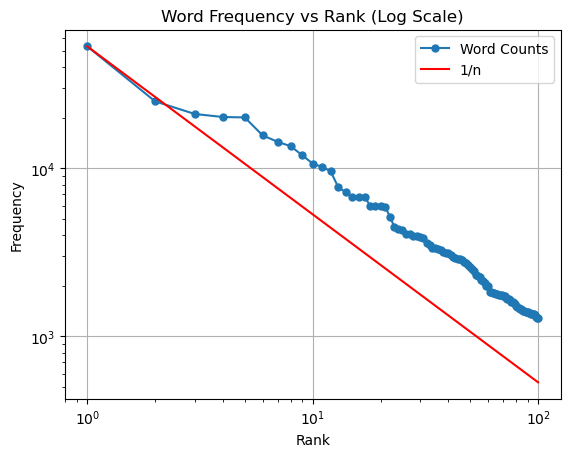

In [12]:
import nltk
nltk.download('stopwords')
import pandas as pd
import re

#reading into CSV
df = pd.read_csv("Edmunds Car Data.csv")

#creating a new column with cleaner data
df["Comment_raw"] = df["Comment"].astype(str)
df["Comment_raw"] = df["Comment_raw"].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df["Comment_raw"] = df["Comment_raw"].apply(lambda x: x.replace("\n", " ").replace("  "," ").lower())

#all cleaned comments in one string
all_comments = " ".join(df["Comment_raw"].tolist())

#cleaning all comments from stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
all_comments_filtered = " ".join([word for word in all_comments.split() if word not in stop_words])

#creating two word counts: raw and without stop words

from collections import Counter
word_counts = Counter(all_comments_filtered.split())
word_counts_raw = Counter(all_comments.split())

#sorting them in ascending order
word_counts = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True))
word_counts_raw = dict(sorted(word_counts_raw.items(), key=lambda item: item[1], reverse=True))

print("The total word count is", sum(word_counts_raw.values()))
print("The total word count (less stopwords) is", sum(word_counts.values()))

#first, let's just plot the raw work count with ranking against 1/x.
import matplotlib.pyplot as plt
import numpy as np

counts = list(word_counts_raw.values())[:100]
ranks = np.arange(1, len(counts)+1)

inv_ranks = 1 / ranks

plt.loglog(ranks, counts, marker='o', linestyle='-', markersize=5)
plt.loglog(ranks, inv_ranks * counts[0], linestyle='-', color='red')  # Plot 1/n line

plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.title("Word Frequency vs Rank (Log Scale)")
plt.legend(["Word Counts", "1/n"])
plt.grid(True)
plt.show()

#we can see that the word line is heavily tilted



We must test whether our distribution of words follows the Ziph's law. To do so, we can represent the relationship between $r$ and $x_{(r)}$ in the following way


$$
\ln r = \theta \ln (\frac{x_r}{nx_n}) + \epsilon
$$

and check whether $\theta =-1$ or anywhere near.

In [13]:
import statsmodels.formula.api as sm

counts = np.array(list(word_counts_raw.values()))
ranks = np.arange(1, len(counts)+1)

inv_ranks = 1 / ranks

n = 1
x_n = ranks[-1]  # x_n is the last element
term_log = np.log(counts / (n * x_n))

data = pd.DataFrame({'ranks_log': np.log(ranks), 'term_log': term_log})

model = sm.ols('ranks_log ~ 0 + term_log', data=data).fit()

print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:              ranks_log   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          1.199e+07
Date:                Fri, 20 Sep 2024   Prob (F-statistic):                        0.00
Time:                        20:00:37   Log-Likelihood:                         -20208.
No. Observations:               30340   AIC:                                  4.042e+04
Df Residuals:                   30339   BIC:                                  4.043e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

P-value of our $\theta$ is very close to zero, meaning it is statistically significant. Its 95% confidence interval is $[-0.995, -0.994]$. While it is not exactly -1, being close enough suggests that our distribution follows a Zipf-like pattern with some deviation. With additional data, it is likely that $\theta$ would converge closer to -1.

## Task B
Find the top 10 brands from frequency counts. You will need to write a script to count the
frequencies of words (stopwords should NOT be counted). Replace frequently occurring car models with
brands so that from now on you have to deal with only brands and not models. You will need another
script for this job. A list of model and brand names (not exhaustive) are provided in a separate file. Even
if a brand (e.g., BMW) is mentioned multiple times in a message, it should be counted as 1.

In [14]:
import csv
import re
import shutil
from tempfile import NamedTemporaryFile
import pandas as pd

# Filepaths
output_file = 'replacement_sample_data.csv'  # The file where the modified data will be stored
input_file = 'Edmunds Car Data.csv'  # The file containing the original data
replacement_file = 'car_models_and_brands.csv'  # The file containing original and replacement words

# Function to load word replacements from a CSV file into a dictionary
def load_replacements(replacement_file):

    replacements = {}
    for _, row in replacement_file.iterrows():
        brand, model = row['Brand'].lower(), row['Model'].lower()
        replacements[model] = brand  # Replace each model with the corresponding brand
    return replacements

# Function to replace words in the input text according to the replacements dictionary
def replace_words_in_text(text, replacements):

    if not isinstance(text, str):
        return text  # Return the original value if it's not a string

    words = text.split()
    new_words = []

    for word in words:
        # Remove punctuation from word to ensure correct replacement
        word_cleaned = re.sub(r'[^\w\s]', '', word.lower())
        # Replace word if it exists in the replacements dictionary
        new_word = replacements.get(word_cleaned, word)
        new_words.append(new_word)

    return ' '.join(new_words)

# Function to process the input file, perform word replacements, and write the modified content to the output file
def process_file(input_file, output_file, replacements):

    # Load the input file into a pandas DataFrame
    edmunds_car_data = pd.read_csv(input_file)

    # Replace words in the 'Comment' column
    edmunds_car_data['Comment'] = edmunds_car_data['Comment'].apply(replace_words_in_text, args=(replacements,))

    # Save the modified DataFrame to the output file
    edmunds_car_data.to_csv(output_file, index=False)

# Main block to run the script
if __name__ == "__main__":

    car_models_and_brands = pd.read_csv(replacement_file)
    replacements = load_replacements(car_models_and_brands)
    # Process the input file and apply the replacements
    process_file(input_file, output_file, replacements)

    print(f"File processed and saved to {output_file}")


File processed and saved to replacement_sample_data.csv


In [15]:
import csv
import re
import string
from collections import defaultdict

# Set of brands, cleaned to handle variations like punctuation and spaces
brands_set = {
    'acura', 'audi', 'bmw', 'buick', 'cadillac', 'chevrolet', 'chrysler', 'dodge', 'ford',
    'honda', 'hyundai', 'infiniti', 'kia', 'lincoln', 'lexus', 'mazda', 'mercedes', 'mercury',
    'mitsubishi', 'nissan', 'pontiac','saturn', 'subaru', 'suzuki', 'toyota', 'volkswagen', 'volvo'
}

# Normalize the brand set to handle variations
normalized_brands = {}
for brand in brands_set:
    # Normalize brands by removing spaces and punctuation, and converting to lowercase
    normalized_key = re.sub(r'[\s\-\.]', '', brand).lower()
    normalized_brands[normalized_key] = brand

# Function to clean and tokenize sentences
def clean_and_tokenize(sentence):
    # Remove punctuation and convert text to lowercase
    sentence = re.sub(f'[{re.escape(string.punctuation)}]', '', sentence.lower())
    # Tokenize by splitting on whitespace
    return sentence.split()

# Function to process the input CSV file
def process_input_file(input_filename):
    brand_freq = defaultdict(int)

    with open(input_filename, 'r', encoding='utf-8') as infile:
        reader = csv.reader(infile)
        next(reader)  # Skip the header row

        for row in reader:
            if row:  # Ensure the row is not empty
                text = row[-1]  # Assuming the relevant text is in the second column (e.g., "Comment" column)
                tokens = clean_and_tokenize(text)
                seen_brands = set()  # Track seen brands in this post to avoid duplicates

                for token in tokens:
                    token = re.sub(r'[^\w\s]', '', token)  # Remove any leftover punctuation
                    if token in normalized_brands:
                        seen_brands.add(normalized_brands[token])

                # Increment the brand frequency for the brands seen in this post
                for brand in seen_brands:
                    brand_freq[brand] += 1

    return brand_freq

# Input file
input_filename = 'replacement_sample_data.csv'  # Make sure this file path is correct

# Get the brand frequencies
brand_frequencies = process_input_file(input_filename)

# Sort and get the top 10 brands by frequency
top_10_brands = sorted(brand_frequencies.items(), key=lambda x: x[1], reverse=True)[:10]

# Output the top 10 brands and their frequencies
for brand, freq in top_10_brands:
    print(f"{brand}: {freq}")

# Optionally, write this to a CSV file
with open('Top_10_Brands.csv', 'w', newline='', encoding='utf-8') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['Brand', 'Frequency'])
    writer.writerows(top_10_brands)



bmw: 3100
lexus: 1124
acura: 931
audi: 916
honda: 758
infiniti: 674
toyota: 638
nissan: 426
mercedes: 345
cadillac: 339


## Task C
Calculate lift ratios for associations between the top-10 brands identified in Task A. You will have
to write a script to do this task). For lift calculations, be sure not to count a mention more than once
per post, even if it is mentioned multiple times in the post. In your code, ensure that a message is not
counted in the lift calculations if the mentions of two brands are separated by more than, say, 5 or 7
words.

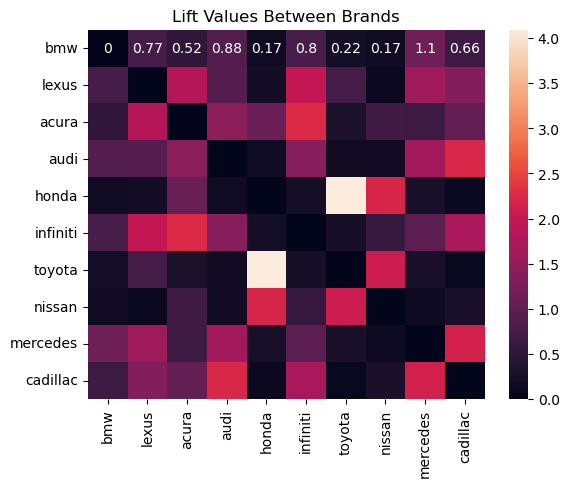

In [16]:
import re
import string
from collections import defaultdict
from itertools import combinations
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize global variables and data structures
df_lift = pd.DataFrame(columns=['word1', 'word2', 'lift_value'])  # To store lift values
word_frequency = defaultdict(int)  # Dictionary to store word frequency in posts
word_pair_frequency = defaultdict(int)  # Dictionary to store word pair co-occurrence frequency
brands_set = {
    'acura', 'audi', 'bmw', 'buick', 'cadillac', 'chevrolet', 'chrysler', 'dodge', 'ford',
    'honda', 'hyundai', 'infiniti', 'kia', 'lincoln', 'lexus', 'mazda', 'mercedes', 'mercury',
    'mitsubishi', 'nissan', 'pontiac','saturn', 'subaru', 'suzuki', 'toyota', 'volkswagen', 'volvo'
}

# Normalize the brand set to handle variations
normalized_brands = {}
for brand in brands_set:
    normalized_key = re.sub(r'[\s\-\.]', '', brand).lower()
    normalized_brands[normalized_key] = brand

# Function to clean and tokenize sentences
def clean_and_tokenize(sentence):
    if isinstance(sentence, str):
        # Remove punctuation and convert text to lowercase
        sentence = re.sub(f'[{re.escape(string.punctuation)}]', '', sentence.lower())
        # Tokenize by splitting on whitespace
        return sentence.split()
    return []  # Return an empty list if sentence is not a string

# Process the input file and calculate word and pair frequencies
def process_and_calculate_lift(df, max_word_distance=5):
    for _, row in df.iterrows():
        text = row['Comment']
        tokens = clean_and_tokenize(text)

        # Find normalized brands in the token list and track their positions
        brand_positions = []
        for i, token in enumerate(tokens):
            token_cleaned = re.sub(r'[^\w\s]', '', token)  # Remove leftover punctuation
            if token_cleaned in normalized_brands:
                brand_positions.append((normalized_brands[token_cleaned], i))

        # Count individual brand mentions
        seen_brands = set([brand for brand, _ in brand_positions])
        for brand in seen_brands:
            word_frequency[brand] += 1

        # Count co-occurrences of brands within the max_word_distance
        for (brand1, pos1), (brand2, pos2) in combinations(brand_positions, 2):
            if abs(pos1 - pos2) <= max_word_distance:
                if brand1 != brand2:
                    pair_key = tuple(sorted([brand1, brand2]))
                    word_pair_frequency[pair_key] += 1

# Calculate lift values
def calculate_lift():
    lift_values = []
    for (brand1, brand2), pair_count in word_pair_frequency.items():
        freq1 = word_frequency[brand1]
        freq2 = word_frequency[brand2]
        lift = (pair_count * file_length) / (freq1 * freq2)
        lift_values.append((brand1, brand2, lift))

    # Convert lift values into a DataFrame
    df_lift = pd.DataFrame(lift_values, columns=['Brand1', 'Brand2', 'Lift'])
    return df_lift

# Get top 10 brands by frequency
def get_top_10_brands():
    sorted_brands = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)
    top_10_brands = [brand for brand, _ in sorted_brands[:10]]
    return top_10_brands

# Create a lift matrix for the top 10 brands
def create_lift_matrix_for_top_10(df_lift, top_10_brands):
    # Initialize an empty matrix for the top 10 brands
    lift_matrix = pd.DataFrame(0, index=top_10_brands, columns=top_10_brands)

    # Populate the matrix with lift values only for the top 10 brands
    for _, row in df_lift.iterrows():
        if row['Brand1'] in top_10_brands and row['Brand2'] in top_10_brands:
            lift_matrix.loc[row['Brand1'], row['Brand2']] = row['Lift']
            lift_matrix.loc[row['Brand2'], row['Brand1']] = row['Lift']  # Symmetric values

    return lift_matrix

# Load the dataset
file_path = 'replacement_sample_data.csv'  # Ensure the correct path
df = pd.read_csv(file_path)
file_length = len(df)  # Number of rows in the input file

# Process the file and calculate lift
process_and_calculate_lift(df)

# Get the lift values
df_lift = calculate_lift()

# Get the top 10 brands
top_10_brands = get_top_10_brands()

# Create and save the lift matrix for the top 10 brands
lift_matrix_top_10 = create_lift_matrix_for_top_10(df_lift, top_10_brands)
lift_matrix_top_10.to_csv('Lift_Matrix_Top_10.csv')

# Or, you can display the result in the console
# print(lift_matrix_top_10)

# Display the heatmap
sns.heatmap(lift_matrix_top_10, annot=True)
plt.title("Lift Values Between Brands")
plt.show()


## Task D:
Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available on GitHub).

C:\Users\argon\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


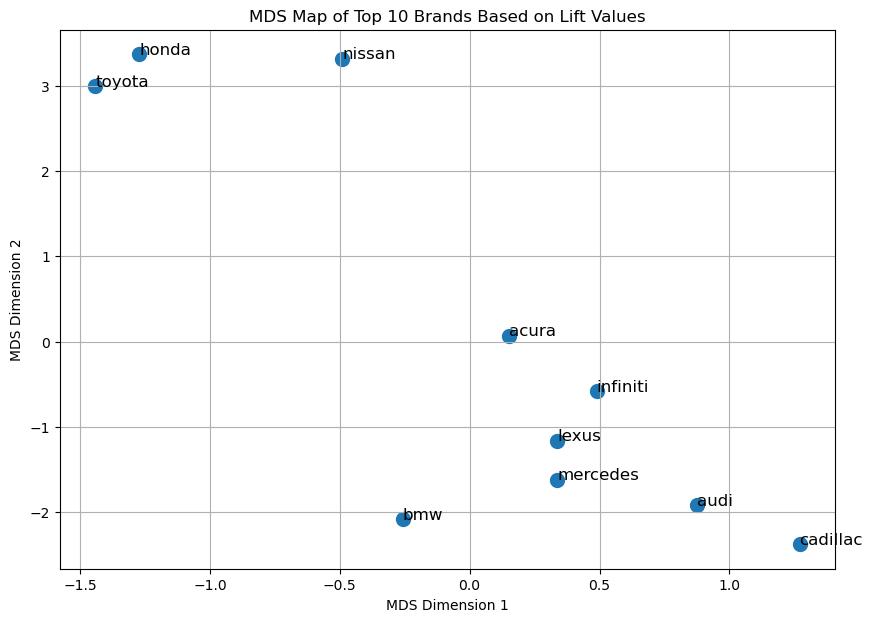

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS

# Load the lift matrix (for top 10 brands) from CSV
lift_matrix_top_10 = pd.read_csv('Lift_Matrix_Top_10.csv', index_col=0)

# Invert lift values for distance calculation (higher lift means closer brands)
# Use a small epsilon to avoid division by zero
epsilon = 1e-6
distance_matrix = 1 / (lift_matrix_top_10 + epsilon)

# Apply MDS to the distance matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_coordinates = mds.fit_transform(distance_matrix)

# Create a scatter plot of the brands in the 2D MDS space
plt.figure(figsize=(10, 7))
plt.scatter(mds_coordinates[:, 0], mds_coordinates[:, 1], s=100)

# Annotate each brand in the plot
for i, brand in enumerate(lift_matrix_top_10.index):
    plt.text(mds_coordinates[i, 0], mds_coordinates[i, 1], brand, fontsize=12)

plt.title('MDS Map of Top 10 Brands Based on Lift Values')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.grid(True)
plt.show()


# Task E:
What insights can you offer to your client from your analyses in Tasks C and D?

We identified a clear grouping in our MDS map. Three brands that were grouped closely together were Toyota, Honda and Nissan. In particular, Toyota and Honda had a high lift value (4.09), indicating frequent comentions between the two brands. All three brands had some of the highest lift ratios compared to any other pairs of brands, signifying that their market niche is clearly defined in the minds of customers. Even if these brands are not as traditionally associated with luxury as some other brands in our analysis, they were still talked about very frequently. Car makers should pay special attention to what steps those car companies are taking to market and design their vehicles, especially when it comes to price-sensitive customers.

On the other hand, one of the most frequently mentioned brands was BMW. However, it does not seem to be frequently mentioned in conjunction with other brands — the highest lift values associated with BMW were with Audi (0.88) and Lexus (0.83), but these are relatively low, which is not significant. A lack of association in this context can indicate that BMW may be more unique compared to the other brands and possibly, it stands out as a well known entry level luxury brand. Its separation from the broader luxury clusters reflects how consumers perceive BMW as a more distinctive brand.

More established luxury brands such as Lexus, Cadillac, Audi, Mercedes, Acura and Infiniti are mentioned together frequently, indicating these may be in a  competitive set; they occupy a similar niche in the market. For example, Acura and Infiniti have a very strong lift value of 2.24. Cadillac also stands out with high lift with Audi (2.22) and with Mercedes (2.13). The tendency to group them together means that more of a discussion is held among users of this forum regarding their relationships. If any one of these brands wants to get a leg up in the field, they could start by targeting the other brands in this cluster as direct competitors and clearly differentiating themselves from others in the market.



# Task F

What are 5 most frequently mentioned attributes or features of cars in the discussions? Which attributes are most strongly associated with which of these 5 brands? There is no need to plot the MDS plot for this question.

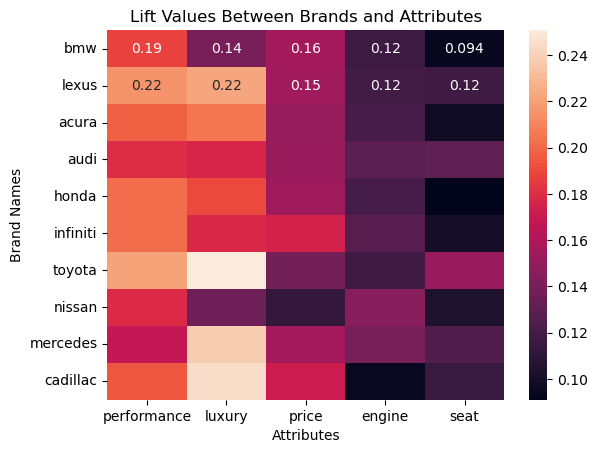

In [18]:
import re
import pandas as pd
from collections import defaultdict
import seaborn as sns

# Attribute list
attribute_list = ['performance', 'luxury', 'reliable', 'safety', 'affordable', 'favorite',
                   'speed', 'comfort', 'warranty', 'price', 'msrp', 'security', 'fuel',
                  'consumption', 'insurance', 'maintainence', 'dependable', 'reliablie',
                  'engine', 'fuel', 'fast', 'gas', 'horsepower', 'mileage', 'seat', 'seats',
                  'safety', 'technology', 'radio', 'gps','wifi', 'driverless', 'charger', 'roof',
                  'sunroof', 'wheels', 'wheel', 'tire', 'tires', 'comfort', 'comfortable','airconditioner',
                  'heat', 'cooling', 'cool', 'heating', 'alarm', 'wireless', 'affordable', 'cheap', 'value', 'expensive']

# Clean attribute list for case-insensitive search
attribute_list = [attr.lower() for attr in attribute_list]

# Top 10 brands (assuming we have this from previous steps)
top_10_brands = lift_matrix_top_10.columns.values

# Dictionary to hold brand-attribute frequencies
brand_attribute_freq = defaultdict(lambda: defaultdict(int))
brand_total_mentions = defaultdict(int)  # To store the total number of mentions for each brand

# Function to clean and tokenize sentences
def clean_and_tokenize(sentence):
    if isinstance(sentence, str):
        # Remove punctuation and convert text to lowercase
        sentence = re.sub(f'[{re.escape(string.punctuation)}]', '', sentence.lower())
        # Tokenize by splitting on whitespace
        return sentence.split()
    return []

# Process the input file and count brand-attribute occurrences
def process_and_count_attributes(df):
    for _, row in df.iterrows():
        text = row['Comment']
        tokens = clean_and_tokenize(text)

        # Track brands and attributes in each comment
        brands_in_comment = set()
        attributes_in_comment = set()

        for token in tokens:
            # Check if token is a brand
            if token in top_10_brands:
                brands_in_comment.add(token)
            # Check if token is an attribute
            if token in attribute_list:
                attributes_in_comment.add(token)

        # For each brand-attribute pair, update the frequency
        for brand in brands_in_comment:
            brand_total_mentions[brand] += 1  # Increment total mentions for the brand
            for attribute in attributes_in_comment:
                brand_attribute_freq[brand][attribute] += 1

# Load the dataset
file_path = 'replacement_sample_data.csv'  # Ensure the correct path
df = pd.read_csv(file_path)

# Process the file to count brand-attribute associations
process_and_count_attributes(df)

# Sum the overall attribute frequencies
attribute_freq = defaultdict(int)
for brand, attributes in brand_attribute_freq.items():
    for attribute, freq in attributes.items():
        attribute_freq[attribute] += freq

# Get the top 5 most frequently mentioned attributes
top_5_attributes = sorted(attribute_freq.items(), key=lambda x: x[1], reverse=True)[:5]
top_5_attributes = [attr for attr, _ in top_5_attributes]

# Create a table showing how often each of the top 5 attributes is mentioned with each brand
brand_attribute_table = pd.DataFrame(index=top_10_brands, columns=top_5_attributes)

for brand in top_10_brands:
    for attribute in top_5_attributes:
        brand_attribute_table.loc[brand, attribute] = brand_attribute_freq[brand][attribute]

# Fill NaN with 0 for missing values and convert to integers
brand_attribute_table = brand_attribute_table.fillna(0).astype(int)

# Normalize the scores by dividing each cell by the total number of mentions for that brand
for brand in top_10_brands:
    total_mentions = brand_total_mentions[brand]
    if total_mentions > 0:
        brand_attribute_table.loc[brand] = brand_attribute_table.loc[brand] / total_mentions

# Display the normalized table
# print(brand_attribute_table)

sns.heatmap(brand_attribute_table, annot=True)
plt.xlabel("Attributes")
plt.ylabel("Brand Names")
plt.title("Lift Values Between Brands and Attributes")
plt.show()

# Optionally, save the normalized result to a CSV
brand_attribute_table.to_csv('Normalized_Brand_Attribute_Associations.csv')


# Task G

What advice will you give to your client from Task F?

The most frequently mentioned attributes appear to be performance, luxury, and price. But since these attributes are mentioned frequently, we know that a lot of people consider these attributes. However, the poor lift associations with the top 10 brands indicate that these attributes are not being mentioned with the top 10 brands very frequently. These lift values cannot be used to derive meaningful insights on the brand’s success or failure in getting people to associate the aforementioned attributes with their products.

However, these lift values suggest that the companies have an opportunity to make their brand synonymous with these attributes by running marketing campaigns, strengthening the association between their brand and these attributes in the minds of customers. These brands should explore strategies and invest more resources to implement innovative marketing campaigns.




# Task H

Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?


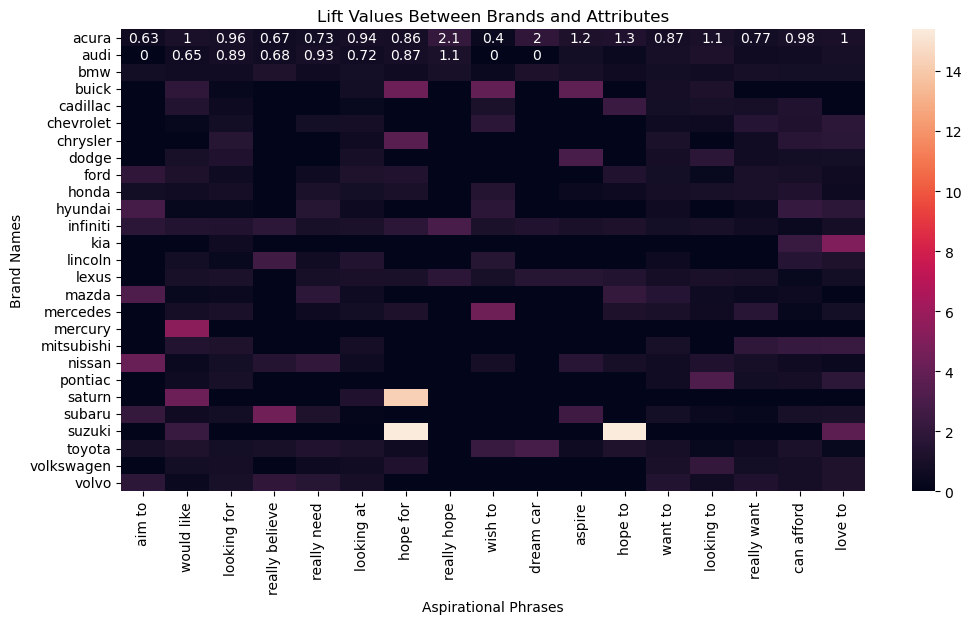

In [20]:
import re
import pandas as pd
from collections import defaultdict
import seaborn as sns

# Aspiration list
aspiration_list = ['aim to', 'would like', 'looking for', 'really believe', 'really need', 'looking at',
                   'hope for', 'really hope', 'wish to', 'dream car', 'aspire', 'hope to', 'want to',
                   'looking to', 'really want', 'can afford', 'love to']

# Top 10 brands (assuming we have this from previous steps)
top_10_brands = ['acura', 'audi', 'bmw', 'buick', 'cadillac', 'chevrolet', 'chrysler', 'dodge', 'ford',
                 'honda', 'hyundai', 'infiniti', 'kia', 'lincoln', 'lexus', 'mazda', 'mercedes', 'mercury',
                 'mitsubishi', 'nissan', 'pontiac','saturn', 'subaru', 'suzuki', 'toyota', 'volkswagen', 'volvo']

# Initialize dictionaries to hold frequencies
brand_freq = defaultdict(int)  # To hold occurrences of each brand
aspiration_freq = defaultdict(int)  # To hold occurrences of each aspirational term
brand_aspiration_freq = defaultdict(lambda: defaultdict(int))  # To hold joint occurrences

# Function to clean and tokenize sentences
def clean_and_tokenize(sentence):
    if isinstance(sentence, str):
        # Remove punctuation and convert text to lowercase
        sentence = re.sub(f'[{re.escape(string.punctuation)}]', '', sentence.lower())
        # Tokenize by splitting on whitespace
        return sentence.split()
    return []

# Check if any aspirational phrase is in the text
def contains_aspiration(text, aspiration_list):
    if isinstance(text, str):  # Ensure the text is a string
        for phrase in aspiration_list:
            if phrase in text.lower():
                return True
    return False

# Process the input file and count brand-aspirational term occurrences
def process_and_count_aspirations(df):
    for _, row in df.iterrows():
        text = row['Comment']
        tokens = clean_and_tokenize(text)

        # Track brands and aspirational phrases in each comment
        brands_in_comment = set()
        aspirations_in_comment = set()

        # Identify brands in the comment
        for token in tokens:
            if token in top_10_brands:
                brands_in_comment.add(token)

        # Identify aspirational phrases in the comment
        if contains_aspiration(text, aspiration_list):
            for phrase in aspiration_list:
                if phrase in text.lower():
                    aspirations_in_comment.add(phrase)

        # Update counts for brands and aspirational terms
        for brand in brands_in_comment:
            brand_freq[brand] += 1
            for aspiration in aspirations_in_comment:
                aspiration_freq[aspiration] += 1
                brand_aspiration_freq[brand][aspiration] += 1

# Load the dataset
file_path = 'replacement_sample_data.csv'  # Ensure the correct path
df = pd.read_csv(file_path)

# Process the file to count brand-aspirational associations
process_and_count_aspirations(df)

# Calculate the lift values and store them in a matrix
lift_matrix = pd.DataFrame(index=top_10_brands, columns=aspiration_list)

total_comments = len(df)

for brand in top_10_brands:
    for aspiration in aspiration_list:
        # Joint probability: P(B ∩ A)
        joint_occurrences = brand_aspiration_freq[brand][aspiration]
        P_B_and_A = joint_occurrences / total_comments

        # Probability of brand: P(B)
        brand_occurrences = brand_freq[brand]
        P_B = brand_occurrences / total_comments

        # Probability of aspirational term: P(A)
        aspiration_occurrences = aspiration_freq[aspiration]
        P_A = aspiration_occurrences / total_comments

        # Calculate lift if P(B) and P(A) are not zero
        if P_B > 0 and P_A > 0:
            lift = P_B_and_A / (P_B * P_A)
            lift_matrix.loc[brand, aspiration] = lift
        else:
            lift_matrix.loc[brand, aspiration] = 0  # If no occurrences, set lift to 0

# Display the matrix
#print(lift_matrix)
for cols in lift_matrix.columns:
    lift_matrix[cols] = lift_matrix[cols].astype(float)

plt.figure(figsize=(12, 6))
sns.heatmap(lift_matrix, annot=True)
plt.xlabel("Aspirational Phrases")
plt.ylabel("Brand Names")
plt.title("Lift Values Between Brands and Attributes")
plt.show()

# Optionally, save the lift matrix to a CSV file
lift_matrix.to_csv('Brand_Aspiration_Lift_Matrix.csv')


In [21]:
median_lift = pd.DataFrame(lift_matrix.median(axis=1)).rename(columns={0: 'Median Lift Value'})
median_lift.sort_values(by='Median Lift Value', ascending=False)

Median Lift Value
infiniti             1.137127
lexus                1.006185
acura                0.959030
toyota               0.950444
volvo                0.863061
nissan               0.838364
honda                0.818520
bmw                  0.759013
mercedes             0.740506
audi                 0.717177
volkswagen           0.695169
dodge                0.661157
subaru               0.640041
ford                 0.636780
chevrolet            0.522575
mazda                0.411455
cadillac             0.322977
lincoln              0.322914
hyundai              0.283447
chrysler             0.000000
mercury              0.000000
mitsubishi           0.000000
buick                0.000000
pontiac              0.000000
saturn               0.000000
kia                  0.000000
suzuki               0.000000

Our approach in determining what it meant to be aspirational centered around identifying aspirational phrases though bigrams. In order to get “aspirational phrases”, we looked at the lift values between phrases that might imply aspiration and the brands we analyzed. Because “dream” and “dream of” can have very different connotations, for example, bigrams better refined our results compared to a simple bag of words approach. Also, we need to consider the fact that the messages are being posted in an informal setting. Thus, people are more likely to use very casual phrases that are likely to appear in conversations with friends or in a low stress environment. Therefore, we include phrases such as “really want” as they may be likely to show up in the corpus. We also used ChatGPT to brainstorm some other slang phrases used in the early 2000’s such as “Big Pimpin’“, “Livin’ Large,” and “Ballin’.”

Many of the lift values were not very significant as many were less than or equal to 1. However, Infiniti seemed to stand out as it had the greatest median value for lift associations with aspirational phrases. This can indicate that there is at least some merit to Infiniti that makes it stand out in comparison to other brands. It is likely that people hold some promise or belief in the brand, meaning Infiniti may have gained some consumer trust. This means that new customers may be more receptive to marketing attempts.

Having an “aspirational” brand backed up by this analysis gives brands some fire power when it comes to marketing. Especially in head-to-head comparative marketing strategies, being able to say that your brand “is more aspirational” than another brand (or generally more aspirational than other top car brands) works great as a way to sell the idea of the car to new potential customers. When combining the findings of our research into lift values between cars and these lift values regarding aspirations, a company like Toyota could emphasize how more people see its brand as touting a “dream car” than Honda, part of their competitive set. With information like this, there are a staggering number of avenues where a car brand can tout their superiority over competing brands, citing “the people” (or, in this case, online forums) as their source. And whom do customers trust more than themselves, represented by the people?

